In [281]:
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_absolute_error

# Data loading, cleaning

In [276]:
path = 'FiveCitiePMData/'
directory_contents = os.listdir(path)

# loading data, creating column with city name
df = pd.DataFrame()
for file in directory_contents:
    df_partial = pd.read_csv(f'{path}{file}')
    df_partial['city'] = file[:-23] #lazy method instead of regexp 
    df = df.append(df_partial)
    
# converting to date time
# df['date_time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['date_time'] = pd.to_datetime(df[['year', 'month', 'day']])
# df['date_'] = df.date_time.dt.date
# dropping unnecessary columns
df.drop(['year', 'month', 'day', 'hour', 'No'], axis=1, inplace=True)
df.head()

<ipython-input-276-80e0f88c9be2>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_partial)
<ipython-input-276-80e0f88c9be2>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_partial)
<ipython-input-276-80e0f88c9be2>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_partial)
<ipython-input-276-80e0f88c9be2>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_partial)
<ipython-input-276-80e0f88c9be2>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_partial)


,season,PM_Jingan,PM_US Post,PM_Xuhui,DEWP,HUMI,PRES,TEMP,cbwd,Iws,...,PM_Taiyuanjie,PM_Xiaoheyan,PM_City Station,PM_5th Middle School,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_Caotangsi,PM_Shahepu,date_time
0,4.0,NaN,NaN,NaN,-6.0,59.48,1026.1,1.0,cv,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01
1,4.0,NaN,NaN,NaN,-6.0,59.48,1025.1,1.0,SE,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01
2,4.0,NaN,NaN,NaN,-7.0,59.21,1025.1,0.0,SE,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01
3,4.0,NaN,NaN,NaN,-6.0,63.94,1024.0,0.0,SE,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01
4,4.0,NaN,NaN,NaN,-6.0,63.94,1023.0,0.0,SE,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-01-01


In [277]:
# splitting columns per type of info
pm_cols = [col for col in df.columns if col.find('PM_') == 0]
meteo_cols = [col for col in df.columns if col.find('PM_') != 0 and col not in ['season', 'city', 'date_time']]
other_cols = ['season', 'city']

print(pm_cols, '\n', meteo_cols, '\n', other_cols)

['PM_Jingan', 'PM_US Post', 'PM_Xuhui', 'PM_Taiyuanjie', 'PM_Xiaoheyan', 'PM_City Station', 'PM_5th Middle School', 'PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_Caotangsi', 'PM_Shahepu'] 
 ['DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec'] 
 ['season', 'city']


In [104]:
# df_model
df_model = df[df.city=='Beijing'][['PM_US Post','date_time']+meteo_cols+other_cols] #.groupby('date_')['PM_US Post'].mean().to_frame('pm25')
df_model['month'] = df_model['date_time'].dt.to_period('M')
df_model.head()


,PM_US Post,date_time,No,year,month,day,hour,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,season,city
0,NaN,2010-01-01,1,2010,2010-01,1,0,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0,4.0,Beijing
1,NaN,2010-01-01,2,2010,2010-01,1,1,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0,4.0,Beijing
2,NaN,2010-01-01,3,2010,2010-01,1,2,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0,4.0,Beijing
3,NaN,2010-01-01,4,2010,2010-01,1,3,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0,4.0,Beijing
4,NaN,2010-01-01,5,2010,2010-01,1,4,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0,4.0,Beijing


In [124]:
df_model2 = df_model.groupby('month').agg({'PM_US Post':'mean', 'TEMP':'mean', 'Iprec': 'max'}) #.reset_index()
df_model2.index = df_model2.index.to_timestamp()
df_model2.head()

,PM_US Post,TEMP,Iprec
month,,,
2010-01,90.403670,-6.162634,11.2
2010-02,97.239940,-1.922619,4.7
2010-03,94.046544,3.293011,10.1
2010-04,80.072423,10.806944,11.9
2010-05,87.071913,20.831989,13.9


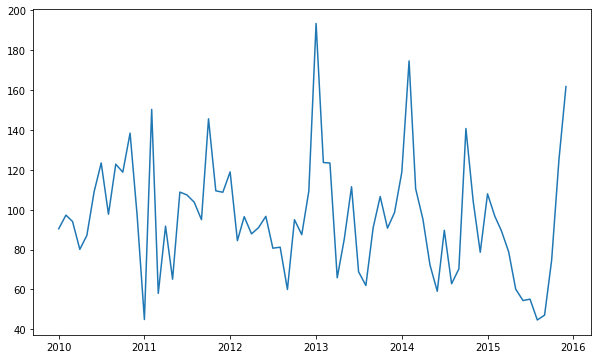

In [249]:
plt.figure(figsize=(10,6))
plt.plot(df_model2.index, df_model2['PM_US Post'])

# Correlation between metrics

<AxesSubplot:>

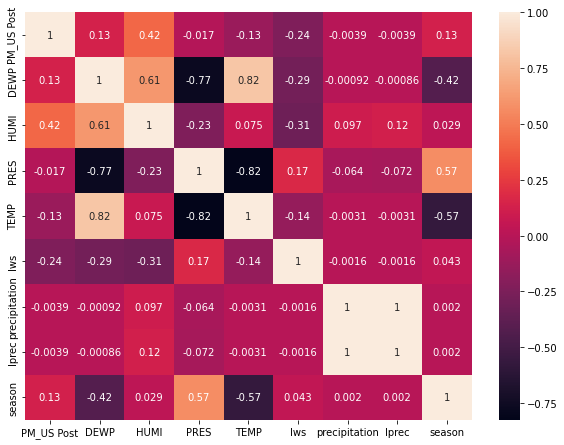

In [278]:
sns.heatmap(df_model[['PM_US Post' ]+meteo_cols+other_cols].corr(), annot=True)

There is high correlation between selected metrics, for example TEMP and PRES, precipitation and lprec. If I was going to use meteo metrics as exogeneus variables, I'd remove first a few ones with high correlation.

# Check for stationarity

In [158]:
ad_fuller_result = adfuller(df_model2['PM_US Post'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.8540918020983133
p-value: 0.8027146575878109


p-value > 0.05 meaning null hypothesis is correct and series is not stationary

## Differentiating

In [250]:
df_model2['pm25'] = np.log(df_model2['PM_US Post'])
df_model2['pm25'] = df_model2['pm25'].diff()

df_model2.head()

,PM_US Post,TEMP,Iprec,pm25
month,,,,
2010-01-01,90.403670,-6.162634,11.2,NaN
2010-02-01,97.239940,-1.922619,4.7,0.072897
2010-03-01,94.046544,3.293011,10.1,-0.033392
2010-04-01,80.072423,10.806944,11.9,-0.160858
2010-05-01,87.071913,20.831989,13.9,0.083803


In [162]:
ad_fuller_result = adfuller(df_model2['pm25'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.1139816809294585
p-value: 9.188599344918683e-08


p-value < 0.05 meaning null hypothesis is rejected, the series is stationary

## Autocorrelation and partial autocorrelation

/Users/katarzynawrona/opt/anaconda3/envs/p3_8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


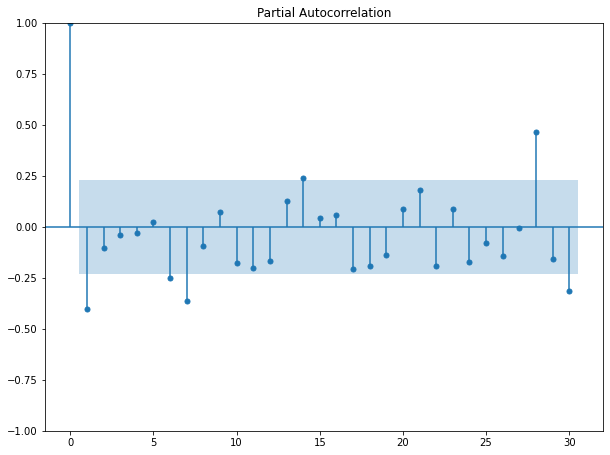

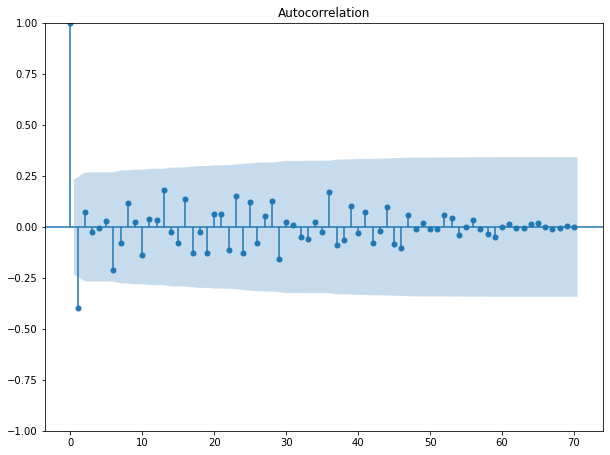

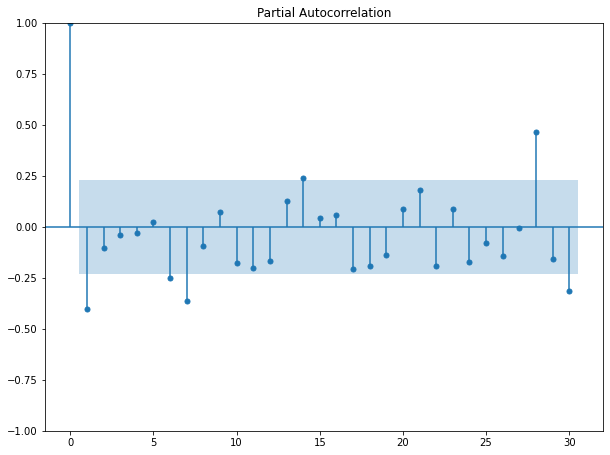

In [164]:
plot_acf(df_model2['pm25'][1:], lags=70)
plot_pacf(df_model2['pm25'][1:], lags=30)

Autocorrelation residuals are lowering in sinusoidal shape- it proves some kind of autocorrelation but gives no clue about the paremtrers value. Partial autocorrelation proves there is a seasonality here.

# Split on train and test data

In [117]:
train = df_model2[:-12]
test = df_model2[-12:]

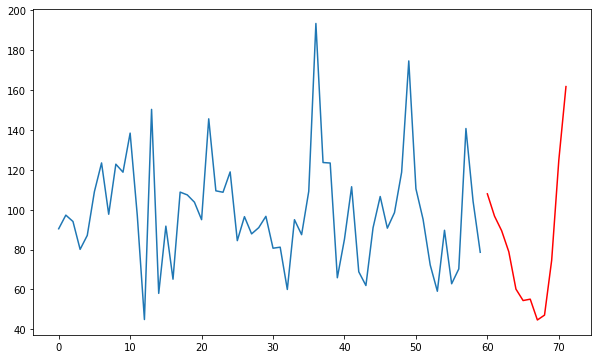

In [118]:
plt.figure(figsize=(10,6))
plt.plot(train['PM_US Post'])
plt.plot(test['PM_US Post'], color='red')

# Seasonal decomposition

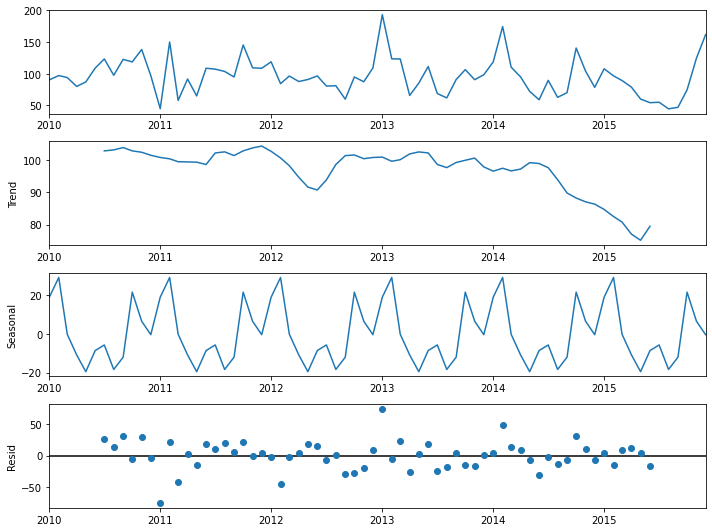

In [167]:
plt.rcParams['figure.figsize'] = [10, 7.5]
result = seasonal_decompose(df_model2[['PM_US Post']], model='additive')
result.plot()
pyplot.show()

# Estimate the parameters

In [138]:
stepwise_model = auto_arima(df_model2[['PM_US Post']], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=631.109, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=605.577, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=610.943, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=584.540, Time=0.32 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=586.503, Time=0.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=594.416, Time=0.16 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=585.911, Time=0.28 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=586.539, Time=0.54 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
Total fit

In [252]:
best_model = SARIMAX(df_model2['PM_US Post'], 
                     order=(1,1,0), 
                     seasonal_order=(2,1,0,12), 
                     simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         PM_US Post   No. Observations:                   72
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -288.270
Date:                            Mon, 07 Feb 2022   AIC                            584.540
Time:                                    19:10:18   BIC                            592.850
Sample:                                01-01-2010   HQIC                           587.784
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4404      0.120     -3.667      0.000      -0.676      -0.205
ar.S.L12      -0.6048      0.102   

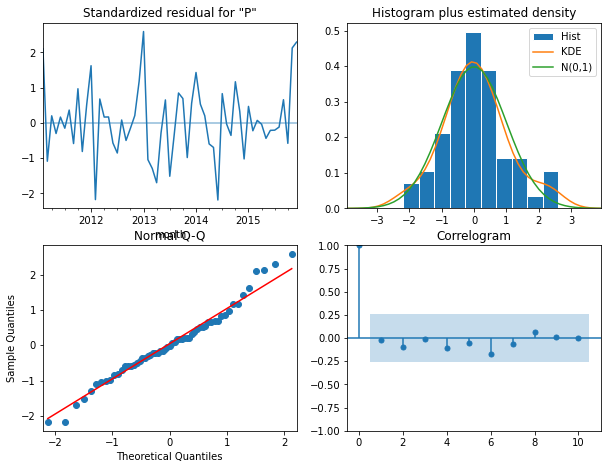

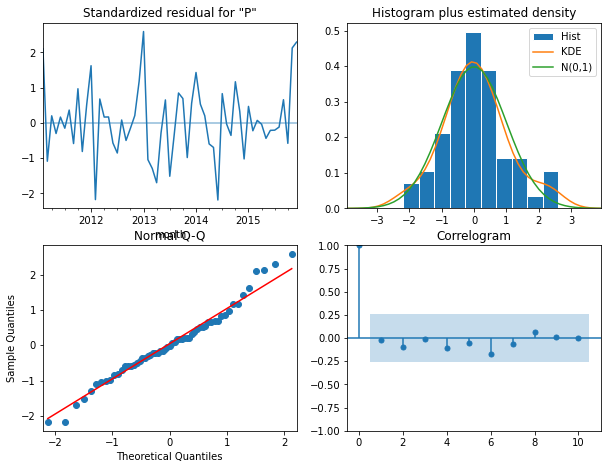

In [260]:
res.plot_diagnostics()

# Evaluate prediction

In [282]:
results_df = pd.DataFrame(data=[predict.predicted_mean[-n_forecast-12:-18].tolist(),
                                test['PM_US Post'].tolist()], 
                          columns=[predict.predicted_mean[-n_forecast-12:-18].index],
                         index=['pred', 'pm25']).T
results_df['variance'] = results_df['pm25'] - results_df['pred']
results_df['variance_pct'] = results_df['variance']/ results_df['pm25']
mse = mean_absolute_error(results_df['pm25'], results_df['pred'])
mape = abs(results_df['variance_pct']).mean()

print(f'ARIMA model MSE:{mse}')
print(f'ARIMA model MAPE:{mape}')

ARIMA model MSE:15.978342409455074
ARIMA model MAPE:0.20805013589505092


# Prediction

In [253]:
n_forecast = 18
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

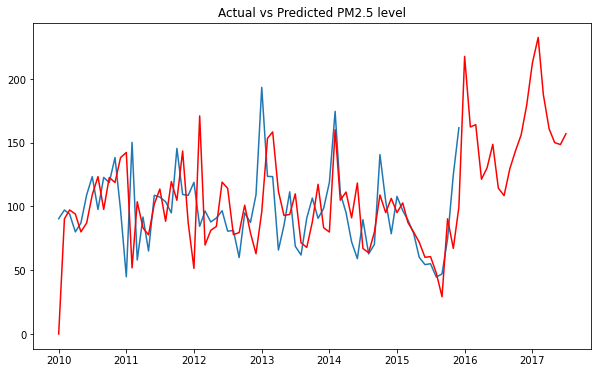

In [259]:
plt.figure(figsize=(10,6))
plt.plot(df_model2['PM_US Post'])
plt.plot(predict.predicted_mean, color='red')
plt.title('Actual vs Predicted PM2.5 level')
plt.show()